# Unsupervised Learning on RECS Dataset
Author(s): Numan Suri

This notebook explores clustering techniques on the RECS (Residential Energy Consumption Survey) dataset, focusing on single-family homes in the Midwest region. The analysis involves several key steps:
1. **Data Preprocessing:** Cleaning, handling missing values, and transforming features.
2. **Dimensionality Reduction:** Using PCA to reduce data dimensions while retaining at least 90% of the variance.
3. **Clustering:** Applying Gaussian Mixture Models (GMM), K-Means, and Hierarchical clustering on the reduced data to group similar households.
4. **Feature Insights:** Analyzing the features driving the clustering decisions.


In [1]:
# Importing necessary libraries for data analysis, preprocessing, and clustering
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

# Set the random seed for reproducibility in results
random_state = 42
sns.set()

# Load the RECS dataset and associated codebook, making sure that the "End-use Model" features are excluded
recs_codebook_df = pd.read_csv('2020_RECS_Code_Book - codebook(1).csv', header=1)
recs_df = pd.read_csv('recs2020_data.csv')

# Display a confirmation message after successfully loading data
print("Codebook and data loaded successfully.")

Codebook and data loaded successfully.


## Preprocessing the Dataset

### Step 1: Data Filtering and Cleaning
- We filter the dataset to focus only on single-family homes in the Midwest.
- To ensure consistent data types, numeric columns are converted to integers where possible, and NaN values are retained.
- Next, we split the data into two subsets:
  1. **df_y:** Contains the features we plan to analyze.
  2. **df_f:** Includes outlier and categorical variables that require special handling.



In [2]:
# Filter for single-family homes (both attached and detached) in the Midwest region
single_family_homes = recs_df[(recs_df['TYPEHUQ'] == 2) | (recs_df['TYPEHUQ'] == 3)]
single_family_homes = single_family_homes[single_family_homes['REGIONC'] == 'MIDWEST']

# A utility function to convert float values to integers where possible, while preserving NaNs
def convert_to_int(x):
    if isinstance(x, float):
        if np.isnan(x):
            return np.nan  # Retain NaN values
        else:
            return int(x)  # Convert floats to integers
    return x

# Applying the conversion function to all numeric values in the dataset
single_family_homes = single_family_homes.applymap(convert_to_int)

# Now we select columns to keep based on the codebook criteria
cols_to_keep = recs_codebook_df[recs_codebook_df['Include'] == 'y']['Variable'].tolist()
cols_to_fix = recs_codebook_df[(recs_codebook_df['Include'] == 'outlier') | 
                               (recs_codebook_df['Include'] == 'category')]['Variable'].tolist()

# Subset the dataframe into two parts: columns to keep and columns to fix
df_y = single_family_homes[cols_to_keep]
df_f = single_family_homes[cols_to_fix]

# Checking how many features were selected for analysis and which ones need to be cleaned
print(f"Selected {len(cols_to_keep)} features for analysis.")
print(f"Selected {len(cols_to_fix)} features for cleaning.")

Selected 49 features for analysis.
Selected 85 features for cleaning.


### Step 2: Handling Outliers and Missing Values

We handle outliers by replacing certain values with more appropriate ones (e.g., replacing '99' with other suitable values). We also address special missing values (e.g., -2) by replacing them with zeros. Once outliers are cleaned, we merge these columns back into the main dataset. 

Finally, we check the number of missing values in each column to see if additional imputation is needed.


In [3]:
# Clean and handle outliers in the selected columns, ensuring consistency
df_f.loc[:, ['USEHUMID', 'H2OMAIN']] = df_f.loc[:, ['USEHUMID', 'H2OMAIN']].replace(99, 5)
df_f.loc[:, ['USECFAN', 'USEDEHUM']] = df_f.loc[:, ['USECFAN', 'USEDEHUM']].replace(99, 0)
df_f.loc[:, ['EQUIPM', 'EQUIPAUXTYPE']] = df_f.loc[:, ['EQUIPM', 'EQUIPAUXTYPE']].replace(99, 15)
df_f.loc[:, 'FUELAUX'] = df_f.loc[:, 'FUELAUX'].replace(99, 9)

# Replace special missing value indicators with 0
df_f.replace(-2, 0, inplace=True)

# Combine the cleaned 'outlier' columns with the main dataset
subset_df = df_y.join(df_f)

# Check the shape of the combined dataset and inspect missing values
print(f"Dataset shape after merging: {subset_df.shape}")
missing_values = subset_df.isnull().sum().sort_values(ascending=False)
print("\nNumber of missing values per column:\n", missing_values.head(10))


Dataset shape after merging: (3095, 134)

Number of missing values per column:
 MEDICALDEV            28
EVHOMEAMT              1
DOEID                  0
NUMWWAC                0
COOLAPT                0
ACEQUIPM_PUB           0
ACEQUIPAGE             0
ACEQUIPAUXTYPE_PUB     0
NUMDLHPAC              0
BASECOOL               0
dtype: int64


/var/folders/xh/4c67ndhd4rggdt_j_x4syjgw0000gn/T/ipykernel_3477/3262551025.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_f.replace(-2, 0, inplace=True)


Here, we drop columns that have too many missing values

In [4]:
# Calculate the number of non-missing values in each column
number_values = subset_df.count()

# Identify columns with more than 25% missing data
threshold = 0.75 * len(subset_df)
cols_to_drop = [col for col in subset_df.columns if subset_df[col].count() < threshold]

# Drop columns with too many missing values
subset_df = subset_df.drop(columns=cols_to_drop)
print(f"Dropped {len(cols_to_drop)} columns due to excessive missing data.")

subset_df = subset_df.dropna()

Dropped 0 columns due to excessive missing data.


### Step 3: Feature Transformation and Normalization

Here we:
1. **Square Root Transformation:** To reduce the skewness in our quantitative variables, we apply a square root transformation.
2. **One-Hot Encoding:** Next, we convert the categorical variables into binary vectors using one-hot encoding, ensuring categorical data is represented correctly for modeling.
2. **Min-Max Scaling:** After the transformation, we normalize the numerical columns to scale them between 0 and 1, preparing the dataset for the next stages of analysis.


In [5]:
# Now let's proceed with normalization and feature transformation

# Split the dataset into numerical and categorical columns
numerical_cols = recs_codebook_df[recs_codebook_df['Type'] == 'Num']['Variable'].tolist()
categorical_cols = recs_codebook_df[recs_codebook_df['Type'] == 'Char']['Variable'].tolist()

numerical_cols = [col for col in numerical_cols if col in subset_df.columns]
categorical_cols = [col for col in categorical_cols if col in subset_df.columns]

# Define the list of quantitative variables for further processing
quant_vars = ['HDD65', 'CDD65', 'HDD30YR_PUB', 'CDD30YR_PUB', 'BEDROOMS', 'NCOMBATH', 
              'NHAFBATH', 'OTHROOMS', 'NUMCFAN', 'NUMFLOORFAN', 'SQFTEST', 'TOTSQFT_EN', 
              'TOTHSQFT', 'TOTCSQFT']

# Ensure no negative values in the relevant columns before applying the square root transformation
subset_df[quant_vars] = subset_df[quant_vars].apply(lambda x: np.where(x < 0, np.nan, x))

# Apply the square root transformation to normalize the data
subset_df[quant_vars] = np.sqrt(subset_df[quant_vars])

# One-hot encode categorical columns
subset_df = pd.get_dummies(subset_df, columns=categorical_cols)

# Apply Min-Max normalization to scale the numerical columns
scaler = MinMaxScaler()
subset_df[numerical_cols] = scaler.fit_transform(subset_df[numerical_cols])

print("Numeric columns successfully transformed and normalized.")

Numeric columns successfully transformed and normalized.


In [6]:
subset_df.head()

,DOEID,HDD65,CDD65,HDD30YR_PUB,CDD30YR_PUB,KOWNRENT,YEARMADERANGE,BEDROOMS,NCOMBATH,NHAFBATH,...,state_postal_NE,state_postal_OH,state_postal_SD,state_postal_WI,BA_climate_Cold,BA_climate_Mixed-Humid,BA_climate_Very-Cold,UATYP10_C,UATYP10_R,UATYP10_U
13,0.000000,1.000000,0.078171,1.000000,0.077010,0.0,0.125,0.816497,0.500000,0.000000,...,False,False,False,False,False,False,True,False,True,False
20,0.000379,0.406801,0.737589,0.329874,0.687488,0.5,0.250,0.577350,0.500000,0.707107,...,False,False,False,False,True,False,False,False,False,True
23,0.000541,0.578472,0.574513,0.463749,0.643970,0.0,0.625,0.707107,0.866025,0.000000,...,False,False,True,False,True,False,False,False,True,False
24,0.000595,0.382791,0.656732,0.340198,0.682943,0.0,0.000,0.577350,0.500000,0.000000,...,False,False,False,False,True,False,False,False,True,False
26,0.000703,0.628872,0.571907,0.654461,0.455618,0.0,0.750,0.912871,0.866025,0.707107,...,False,False,False,False,True,False,False,False,False,True


### Step 4: Dimensionality Reduction with PCA

To reduce the dimensionality of our dataset while preserving the majority of the variance, we apply Principal Component Analysis (PCA). This allows us to simplify the dataset, making the clustering process more efficient. We plot the cumulative explained variance to determine how many components are needed to retain 90% of the variance.


In [7]:
# Perform PCA to capture 90% of the variance
pca = PCA(n_components=0.90, random_state=42)
pca_result = pca.fit_transform(subset_df)

print(f"PCA reduced the dataset to {pca_result.shape[1]} principal components.")

# Create cumulative explained variance
explained_variance = np.cumsum(pca.explained_variance_ratio_)

# Determine the number of components that explain at least 90% of the variance
components_90_variance = np.argmax(explained_variance >= 0.90) + 1
print(f"Number of components explaining at least 90% variance: {components_90_variance}")

pca_90 = PCA(n_components=components_90_variance, random_state=42)
pca_90_result = pca_90.fit_transform(subset_df)

PCA reduced the dataset to 56 principal components.
Number of components explaining at least 90% variance: 56


### Step 5: Finding Optimal Clusters with Gaussian Mixture Models (GMM)

We apply Gaussian Mixture Models (GMM) to the PCA-reduced dataset, exploring a range of components (clusters) to find the optimal number. The Bayesian Information Criterion (BIC) is used to evaluate and choose the best-fitting model. The plot helps visualize which number of clusters minimizes the BIC, guiding us in selecting the optimal number of clusters.


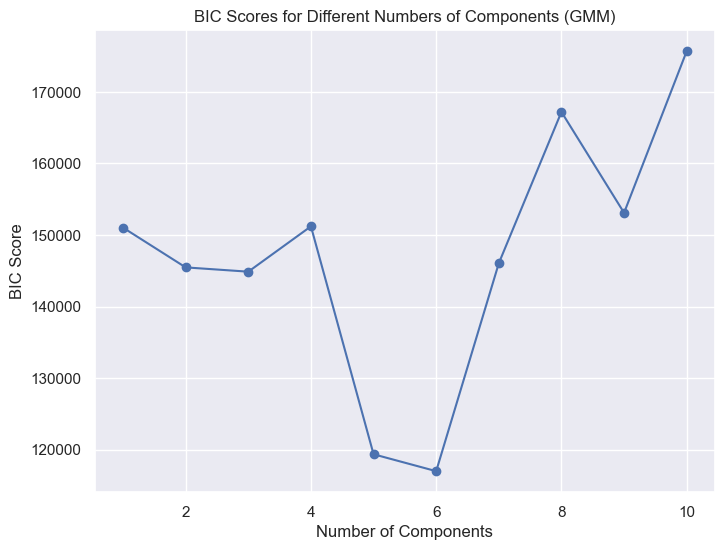

Optimal number of clusters: 6


In [8]:
# Apply Gaussian Mixture Model (GMM) clustering
n_components = np.arange(1, 11)
bics = []

# Fit GMM with different numbers of components and calculate BIC for each
for n in n_components:
    gmm = GaussianMixture(n_components=n, random_state=random_state)
    gmm.fit(pca_result)
    bics.append(gmm.bic(pca_result))

# Plot the BIC scores to identify the optimal number of clusters
plt.figure(figsize=(8, 6))
plt.plot(n_components, bics, marker='o')
plt.title('BIC Scores for Different Numbers of Components (GMM)')
plt.xlabel('Number of Components')
plt.ylabel('BIC Score')
plt.grid(True)
plt.show()

# Optimal number of clusters based on BIC
optimal_n = n_components[np.argmin(bics)]
print(f"Optimal number of clusters: {optimal_n}")


### Step 6: Gaussian Mixture Model (GMM) Clustering

Using the optimal number of clusters determined by the BIC, we fit the GMM model to the PCA-reduced dataset. We then assign cluster labels to each data point. The clustering results are visualized using the first two principal components.

The **silhouette score** is also computed to evaluate the compactness and separation of the clusters, giving us insight into the clustering quality.


/var/folders/xh/4c67ndhd4rggdt_j_x4syjgw0000gn/T/ipykernel_3477/373171365.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  subset_df['GMM_Cluster'] = gmm_labels


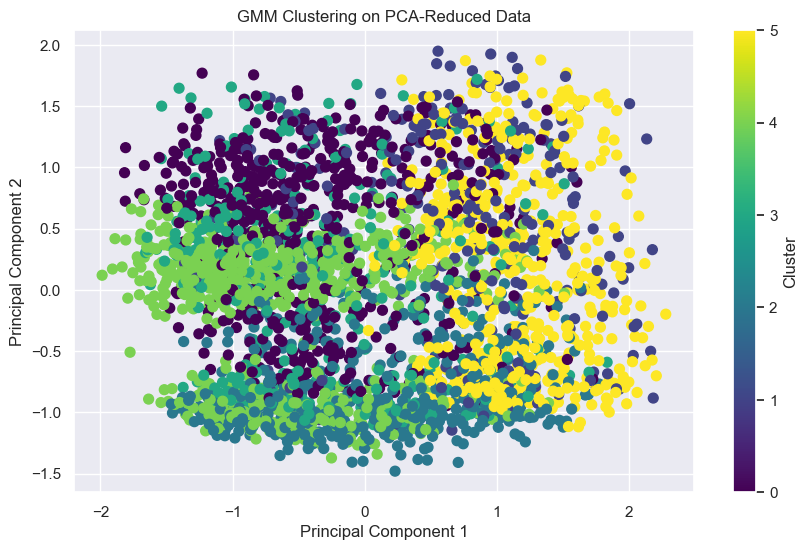

Silhouette Score for GMM clustering: 0.0317


In [9]:
# Fit the GMM with the optimal number of components
gmm = GaussianMixture(n_components=optimal_n, random_state=random_state)
gmm.fit(pca_result)

# Predict the cluster labels for the dataset
gmm_labels = gmm.predict(pca_result)

# Add the predicted cluster labels to the original dataframe
subset_df['GMM_Cluster'] = gmm_labels

# Visualize the clustering using the first two PCA components
plt.figure(figsize=(10, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=gmm_labels, cmap='viridis', s=50)
plt.title('GMM Clustering on PCA-Reduced Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster')
plt.show()

# Calculate the silhouette score to assess the quality of the clustering
from sklearn.metrics import silhouette_score
silhouette_avg = silhouette_score(pca_result, gmm_labels)
print(f'Silhouette Score for GMM clustering: {silhouette_avg:.4f}')


### Step 7: K-Means Clustering

We perform K-Means clustering on the PCA-reduced dataset using the optimal number of clusters. Like GMM, the clustering results are visualized using the first two principal components. The silhouette score is calculated again to compare the performance of K-Means clustering with the GMM approach.


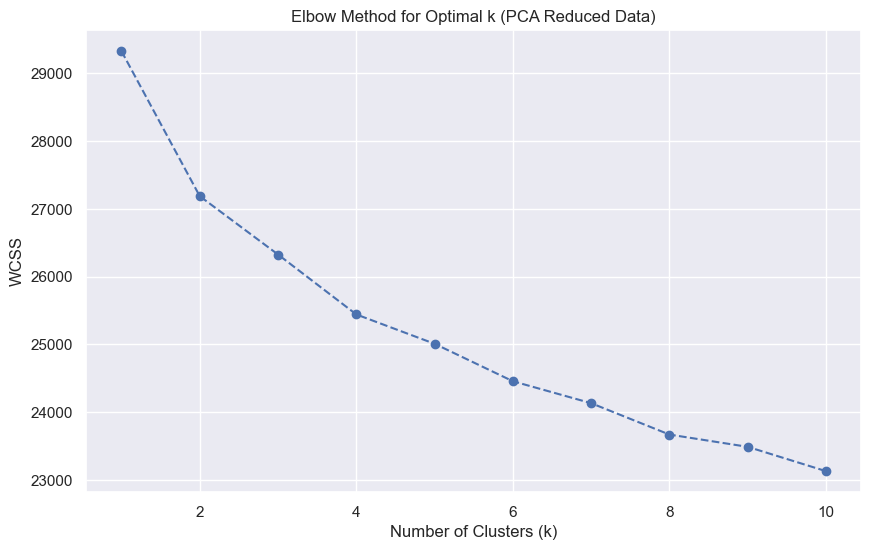

In [10]:
# Calculate WCSS (within-cluster sum of squares) for different values of k
wcss = []
K = range(1, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(pca_90_result)
    wcss.append(kmeans.inertia_)

# Plot the Elbow Method graph
plt.figure(figsize=(10, 6))
plt.plot(K, wcss, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal k (PCA Reduced Data)')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS')
plt.grid(True)
plt.show()

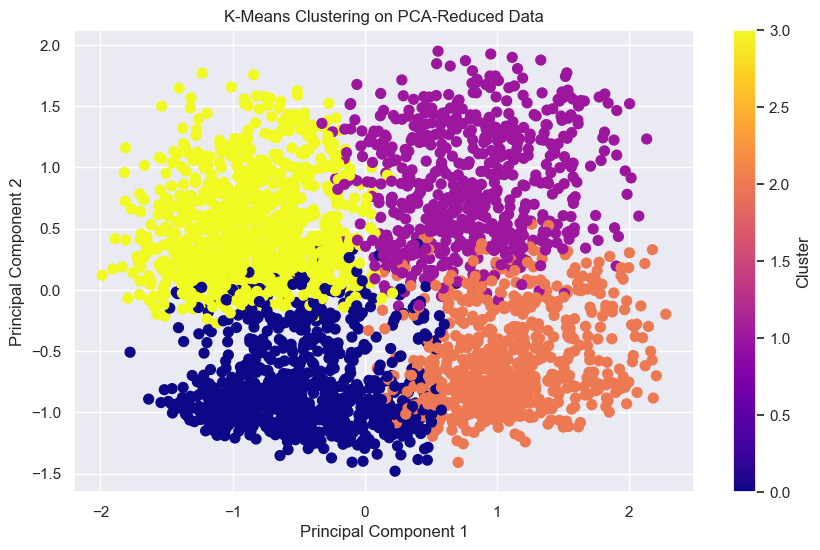

Silhouette Score: 0.052431236206745516


In [11]:
# Perform K-means clustering with the chosen k
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans_labels = kmeans.fit_predict(pca_90_result)

# Visualize the K-Means clustering
plt.figure(figsize=(10, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=kmeans_labels, cmap='plasma', s=50)
plt.title('K-Means Clustering on PCA-Reduced Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster')
plt.show()

# Calculate the silhouette score to assess the quality of the clustering
silhouette_avg = silhouette_score(pca_90_result, kmeans_labels)
print(f'Silhouette Score: {silhouette_avg}')

### Step 8: Hierarchical Clustering

We apply hierarchical clustering to the PCA-reduced dataset, using Ward's method to minimize variance within clusters. A dendrogram is plotted to visualize how the data points are hierarchically grouped.

After fitting the model with the optimal number of clusters, the clustering results are visualized. We calculate the silhouette score again to assess the clustering performance.

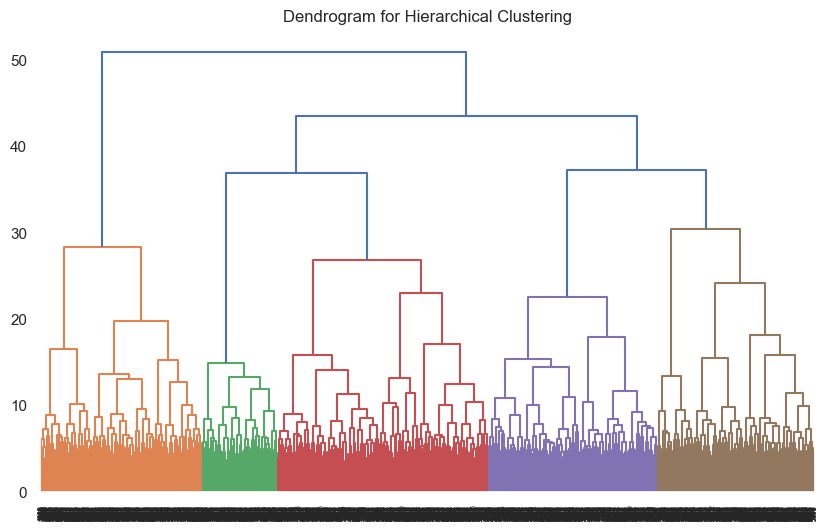

In [12]:
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as shc

# Plot dendrogram to visualize hierarchical clustering
plt.figure(figsize=(10, 6))
plt.title("Dendrogram for Hierarchical Clustering")
dend = shc.dendrogram(shc.linkage(pca_result, method='ward'))
plt.show()

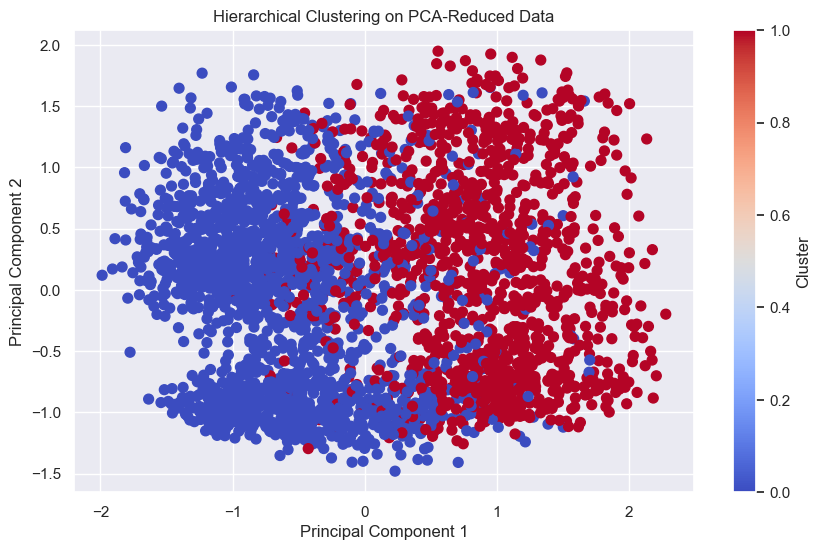

Silhouette Score for Hierarchical clustering: 0.0614


In [13]:
# Perform Hierarchical Clustering with chosen clusters
hierarchical = AgglomerativeClustering(n_clusters=2, metric='euclidean', linkage='ward')
hierarchical_labels = hierarchical.fit_predict(pca_90_result)  

# Visualize hierarchical clustering results using PCA components
plt.figure(figsize=(10, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=hierarchical_labels, cmap='coolwarm', s=50)
plt.title('Hierarchical Clustering on PCA-Reduced Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster')
plt.show()

# Silhouette score for hierarchical clustering
silhouette_avg_hierarchical = silhouette_score(pca_result, hierarchical_labels)
print(f'Silhouette Score for Hierarchical clustering: {silhouette_avg_hierarchical:.4f}')

### Step 9: Cluster Profiling

To understand the characteristics of each cluster, we generate summary statistics (mean, median, min, max) for the numerical variables. This allows us to explore how different clusters differ in terms of energy consumption and household features.

For this step, we profile the clusters generated by all three cluster methods explored above.


In [14]:
# Generate summary statistics for each cluster (numerical columns only)
def get_cluster_summary(data, cluster_labels):
    data['Cluster'] = cluster_labels
    # Select only numerical columns
    numeric_data = data.select_dtypes(include=[np.number])
    summary = numeric_data.groupby('Cluster').agg(['mean', 'median', 'min', 'max'])
    return summary

# Applying to all cluster types
gmm_summary = get_cluster_summary(subset_df.copy(), gmm_labels)
kmeans_summary = get_cluster_summary(subset_df.copy(), kmeans_labels)
hierarchical_summary = get_cluster_summary(subset_df.copy(), hierarchical_labels)


gmm_summary

DOEID                                   HDD65                      \
             mean    median       min       max      mean    median       min   
Cluster                                                                         
0        0.492745  0.475598  0.000000  0.995455  0.636810  0.636050  0.310646   
1        0.493830  0.493642  0.000866  0.993724  0.539779  0.487659  0.112234   
2        0.496339  0.498701  0.000379  0.999297  0.517639  0.506622  0.298624   
3        0.505157  0.530246  0.003301  0.999188  0.263137  0.264211  0.090569   
4        0.484378  0.470782  0.000703  0.998160  0.542671  0.510747  0.298467   
5        0.504443  0.494752  0.006601  1.000000  0.415398  0.408043  0.000000   

                      CDD65            ... EVHOMEAMT           EVCHRGTYPE  \
              max      mean    median  ...       min       max       mean   
Cluster                                ...                                  
0        1.000000  0.484065  0.491677  ...       0.0  0.500000   0.001686   
1        0.980591  0.516002  0.547038  ...       0.0  1.000000   0.007194   
2        0.895343  0.550263  0.561935  ...       0.0  0.333333   0.007619   
3        0.401236  0.800303  0.799096  ...       0.0  0.666667   0.006925   
4        0.903845  0.564186  0.570340  ...       0.0  1.000000   0.012451   
5        0.940478  0.642277  0.641321  ...       0.0  0.333333   0.000916   

                         GMM_Cluster                 
        median  min  max        mean median min max  
Cluster                                              
0          0.0  0.0  0.5         0.0    0.0   0   0  
1          0.0  0.0  1.0         1.0    1.0   1   1  
2          0.0  0.0  1.0         2.0    2.0   2   2  
3          0.0  0.0  1.0         3.0    3.0   3   3  
4          0.0  0.0  1.0         4.0    4.0   4   4  
5          0.0  0.0  0.5         5.0    5.0   5   5  

[6 rows x 524 columns]

In [15]:
kmeans_summary

DOEID                                   HDD65                      \
             mean    median       min       max      mean    median       min   
Cluster                                                                         
0        0.494150  0.484147  0.000541  0.999297  0.517451  0.507998  0.127366   
1        0.500410  0.509252  0.000000  0.997132  0.497004  0.472279  0.000000   
2        0.518927  0.515934  0.000379  1.000000  0.456409  0.444230  0.127189   
3        0.475607  0.458121  0.000703  0.999188  0.518502  0.505245  0.125594   

                      CDD65            ... EVHOMEAMT           EVCHRGTYPE  \
              max      mean    median  ...       min       max       mean   
Cluster                                ...                                  
0        0.939051  0.577030  0.570340  ...       0.0  0.333333   0.008897   
1        1.000000  0.570943  0.578409  ...       0.0  1.000000   0.003931   
2        0.980699  0.605551  0.611508  ...       0.0  0.333333   0.001558   
3        0.991443  0.583211  0.574513  ...       0.0  1.000000   0.008995   

                         GMM_Cluster                 
        median  min  max        mean median min max  
Cluster                                              
0          0.0  0.0  1.0    2.226572    2.0   0   4  
1          0.0  0.0  1.0    2.948113    4.0   0   5  
2          0.0  0.0  0.5    3.297508    3.0   0   5  
3          0.0  0.0  1.0    2.459259    3.0   0   4  

[4 rows x 524 columns]

In [16]:
hierarchical_summary

DOEID                                   HDD65                      \
             mean    median       min       max      mean    median       min   
Cluster                                                                         
0        0.489378  0.473488  0.000000  0.999188  0.518525  0.506003  0.127011   
1        0.502974  0.503246  0.000541  1.000000  0.474931  0.458597  0.000000   

                      CDD65            ... EVHOMEAMT      EVCHRGTYPE         \
              max      mean    median  ...       min  max       mean median   
Cluster                                ...                                    
0        1.000000  0.579643  0.572690  ...       0.0  1.0   0.008811    0.0   
1        0.980591  0.589457  0.592299  ...       0.0  1.0   0.002800    0.0   

                  GMM_Cluster                 
         min  max        mean median min max  
Cluster                                       
0        0.0  1.0    2.384912    3.0   0   5  
1        0.0  1.0    3.089600    4.0   0   5  

[2 rows x 524 columns]

### Step 10: Feature Importance for Cluster Separation

Using a Random Forest classifier, we can determine which features were most important in driving the separation of clusters. This helps us identify which variables (e.g., energy consumption, home characteristics) contributed most to the clustering structure.

The top 10 important features are listed, providing insight into the factors that define each cluster. 

Like the cells above, we will see the feature importances for each cluster type previoulsy explored


In [17]:
# Use RandomForestClassifier to evaluate feature importance for clustering
from sklearn.ensemble import RandomForestClassifier

# Define a function to calculate feature importance using RandomForest for different clustering labels
def calculate_feature_importance(cluster_labels, cluster_name):
    # Initialize the RandomForestClassifier
    rf = RandomForestClassifier(n_estimators=100, random_state=random_state)
    
    # Fit the model on the data (excluding the current cluster labels)
    rf.fit(subset_df.drop(columns=[cluster_name]), cluster_labels)
    
    # Get feature importances
    importances = rf.feature_importances_
    
    # Create a DataFrame for feature importances and sort by importance
    feature_importance_df = pd.DataFrame({'Feature': subset_df.drop(columns=[cluster_name]).columns, 'Importance': importances})
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
    
    # Display the top 10 important features
    print(f"\nTop Features Driving {cluster_name} Cluster Separation:\n", feature_importance_df.head(10))
    
    return feature_importance_df

# Run RandomForest feature importance for GMM clusters
gmm_importances = calculate_feature_importance(gmm_labels, 'GMM_Cluster')

# Get the top 3 features for GMM clusters
top_3_gmm_features = gmm_importances['Feature'].head(3).tolist()



Top Features Driving GMM_Cluster Cluster Separation:
                     Feature  Importance
46                   CELLAR    0.084385
148               UATYP10_U    0.075357
108                 H2OMAIN    0.045738
78                 BASEHEAT    0.030644
1                     HDD65    0.030025
147               UATYP10_R    0.029687
3               HDD30YR_PUB    0.028342
144  BA_climate_Mixed-Humid    0.028292
2                     CDD65    0.027797
43                      GWT    0.026050


In [18]:
# Run RandomForest feature importance for K-Means clusters
subset_df['KMeans_Cluster'] = kmeans_labels  # Add KMeans cluster labels to the dataframe temporarily
kmeans_importances = calculate_feature_importance(kmeans_labels, 'KMeans_Cluster')

# Get the top 3 features for K-Means clusters
top_3_kmeans_features = kmeans_importances['Feature'].head(3).tolist()


/var/folders/xh/4c67ndhd4rggdt_j_x4syjgw0000gn/T/ipykernel_3477/4170232292.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  subset_df['KMeans_Cluster'] = kmeans_labels  # Add KMeans cluster labels to the dataframe temporarily



Top Features Driving KMeans_Cluster Cluster Separation:
          Feature  Importance
73       FUELAUX    0.107800
74   USEEQUIPAUX    0.094759
72      EQUIPAUX    0.094024
90      BASECOOL    0.090004
71  EQUIPAUXTYPE    0.087699
78      BASEHEAT    0.075427
50       BASEFIN    0.065648
39      TOTCSQFT    0.032037
46        CELLAR    0.031005
75     NUMPORTEL    0.025075


In [19]:
# Run RandomForest feature importance for Hierarchical clusters
subset_df['Hierarchical_Cluster'] = hierarchical_labels  # Add hierarchical cluster labels to the dataframe temporarily
hierarchical_importances = calculate_feature_importance(hierarchical_labels, 'Hierarchical_Cluster')

# Get the top 3 features for Hierarchical clusters
top_3_hierarchical_features = hierarchical_importances['Feature'].head(3).tolist()


/var/folders/xh/4c67ndhd4rggdt_j_x4syjgw0000gn/T/ipykernel_3477/3501666846.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  subset_df['Hierarchical_Cluster'] = hierarchical_labels  # Add hierarchical cluster labels to the dataframe temporarily



Top Features Driving Hierarchical_Cluster Cluster Separation:
             Feature  Importance
90         BASECOOL    0.134063
78         BASEHEAT    0.092890
46           CELLAR    0.053630
50          BASEFIN    0.045562
149     GMM_Cluster    0.044617
39         TOTCSQFT    0.041492
150  KMeans_Cluster    0.035434
108         H2OMAIN    0.031995
38         TOTHSQFT    0.028247
54         PRKGPLC1    0.018750


Lastly, I want to visualize the top 3 features for each cluster type

Top 3 Features for GMM Clusters:


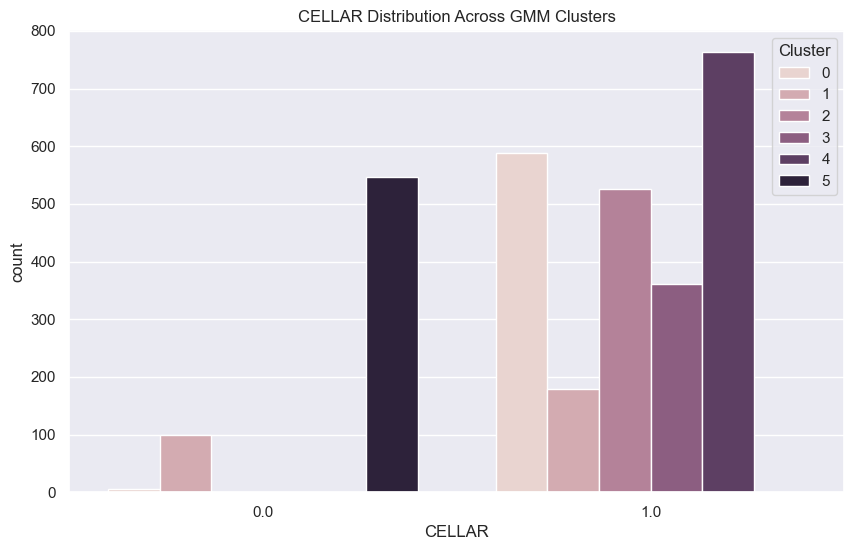

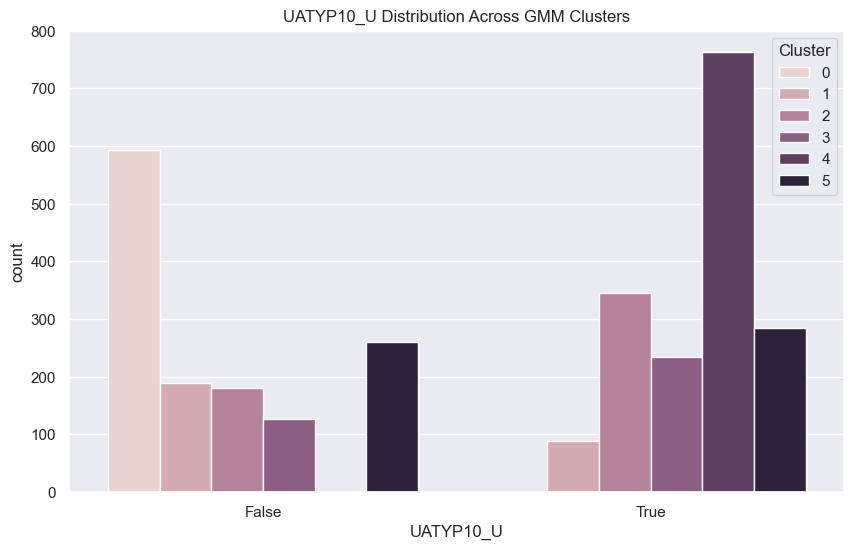

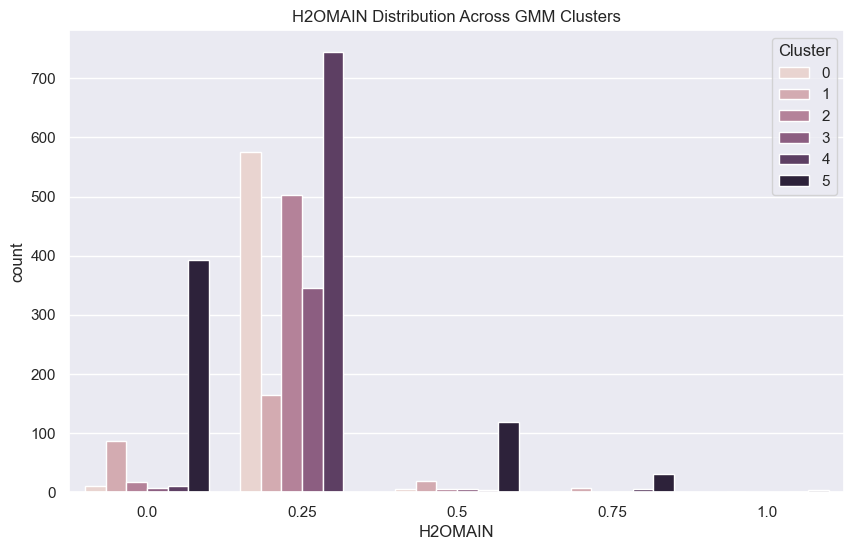

In [20]:
# Function to plot the distribution of top features across clusters
def plot_top_features_distributions(data, cluster_labels, top_features, cluster_name):
    # Add the cluster labels to the data
    data['Cluster'] = cluster_labels
    
    # Iterate over the top features and plot their distribution across clusters
    for col in top_features:
        plt.figure(figsize=(10, 6))
        
        # Check if the feature is categorical or numerical
        if data[col].dtype == 'object' or data[col].nunique() < 10:
            sns.countplot(x=col, hue='Cluster', data=data)
            plt.title(f'{col} Distribution Across {cluster_name} Clusters')
        else:
            sns.boxplot(x='Cluster', y=col, data=data)
            plt.title(f'{col} Distribution Across {cluster_name} Clusters')
        
        plt.show()

# Plot the distributions for GMM clusters
print("Top 3 Features for GMM Clusters:")
plot_top_features_distributions(subset_df.copy(), gmm_labels, top_3_gmm_features, 'GMM')


Top 3 Features for K-Means Clusters:


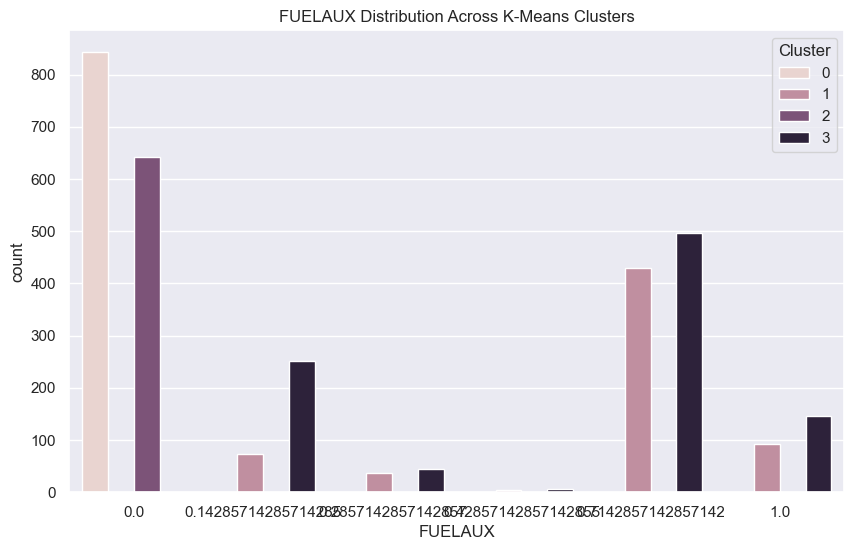

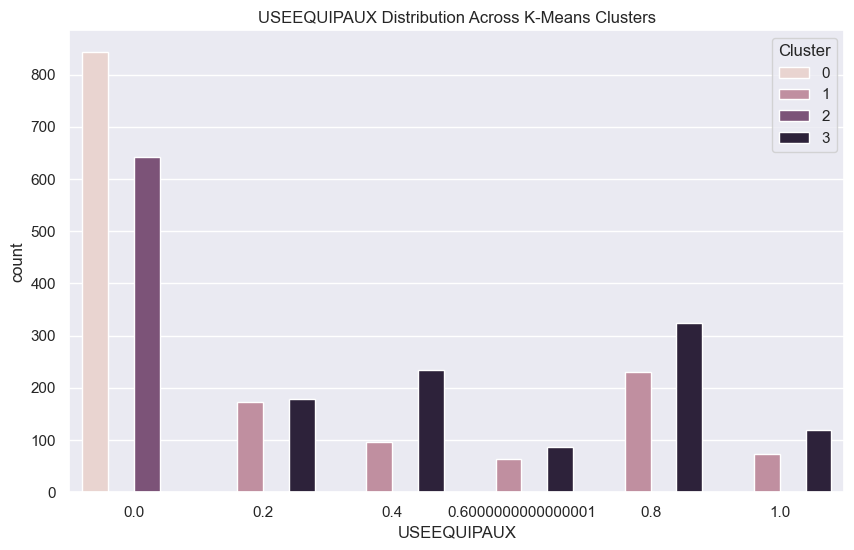

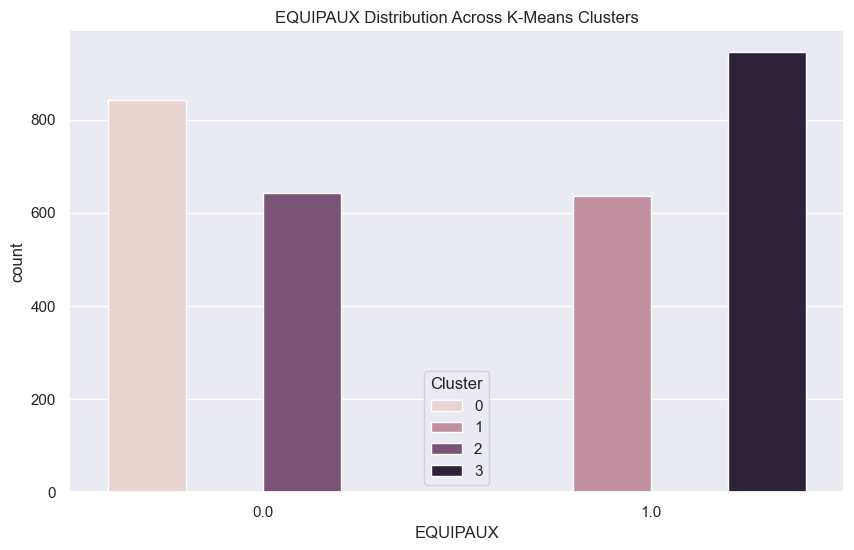

In [21]:
# Plot the distributions for K-Means clusters
print("Top 3 Features for K-Means Clusters:")
plot_top_features_distributions(subset_df.copy(), kmeans_labels, top_3_kmeans_features, 'K-Means')

Top 3 Features for Hierarchical Clusters:


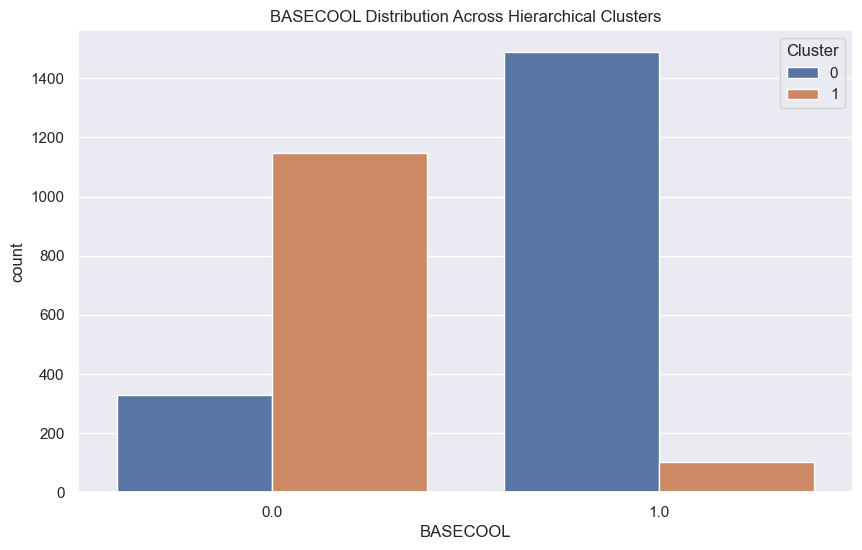

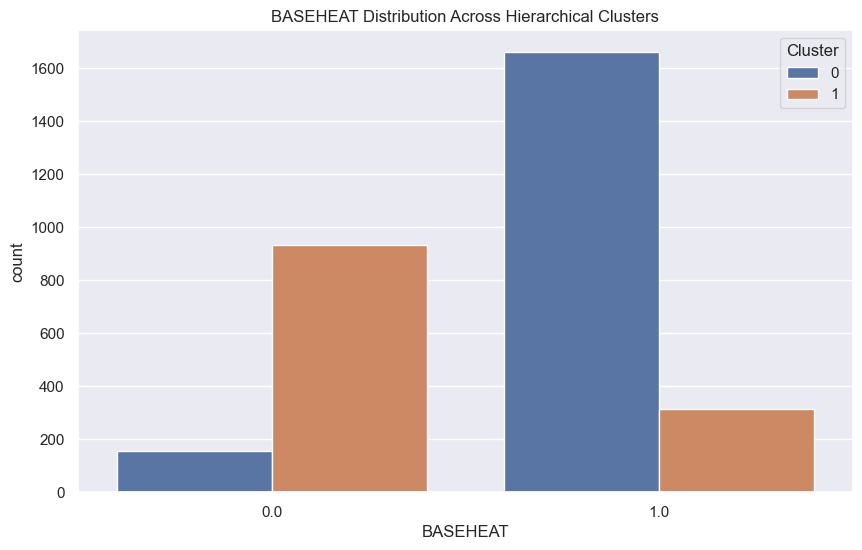

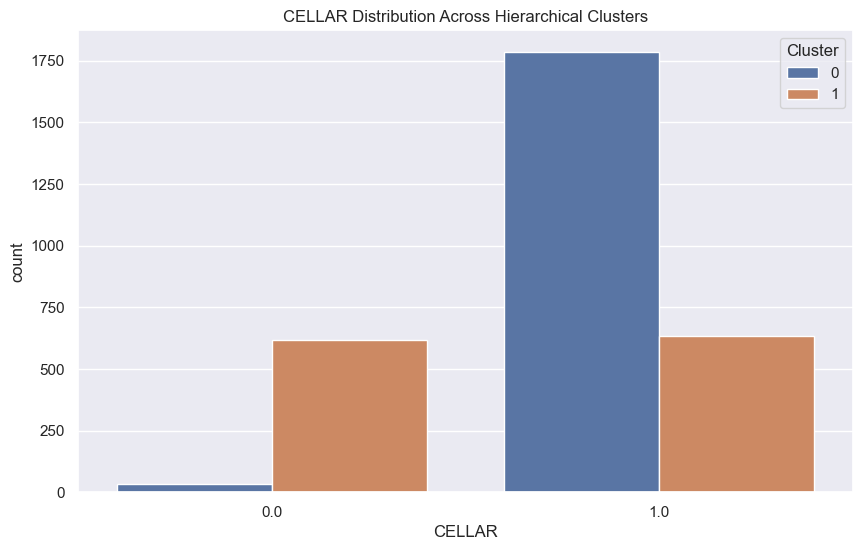

In [22]:
# Plot the distributions for Hierarchical clusters
print("Top 3 Features for Hierarchical Clusters:")
plot_top_features_distributions(subset_df.copy(), hierarchical_labels, top_3_hierarchical_features, 'Hierarchical')
